In [1]:
from IPython.display import Image
from time import sleep
from sklearn.metrics import r2_score
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
ts = '{:%Y%m%d%H%M%S}'.format(datetime.now())

In [2]:
from amb_sdk.sdk import DarwinSdk
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')

status, msg = ds.auth_login_user('nathanalvarezolson@utexas.edu', 'Hmy35qPZM4')
print('You are logged in.' if status else msg)

You are logged in.


In [ ]:
# ds.get_info()
# ds.lookup_job_status()
# ds.lookup_job_status_name(job_name)
# ds.delete_job(job_name)
# ds.stop_job(job_name) 


# Data Upload
**Read dataset and view a file snippet**

In [3]:
DATASET_NAME = 'cycle_weather_by_day_with_avgs_no_mode.csv'

df = pd.read_csv('./data/'+ DATASET_NAME)
#print(df.dtypes)
df.head()

,Date,Month,Year,Weekday,Avg Trip Duration,Total Rides,TempHighF,TempAvgF,DewPointHighF,DewPointAvgF,WindHighMPH,WindAvgMPH,PrecipitationSumInches,Events,PrecipBins
0,2013-12-21,12,2013,5,29.136,103,74,60,67,49,20,4,0.460,"Rain , Thunderstorm",0.1-0.5
1,2013-12-22,12,2013,6,40.462,117,56,48,43,36,16,6,0.000,Sunny,0
2,2013-12-23,12,2013,0,55.604,96,58,45,31,27,8,3,0.000,Sunny,0
3,2013-12-24,12,2013,1,31.965,85,61,46,36,28,12,4,0.000,Sunny,0
4,2013-12-25,12,2013,2,49.297,145,58,50,44,40,10,2,0.005,Sunny,0.1-0.5


In [4]:
df = df[df['Avg Trip Duration'] <= 60]

df.head()

,Date,Month,Year,Weekday,Avg Trip Duration,Total Rides,TempHighF,TempAvgF,DewPointHighF,DewPointAvgF,WindHighMPH,WindAvgMPH,PrecipitationSumInches,Events,PrecipBins
0,2013-12-21,12,2013,5,29.136,103,74,60,67,49,20,4,0.460,"Rain , Thunderstorm",0.1-0.5
1,2013-12-22,12,2013,6,40.462,117,56,48,43,36,16,6,0.000,Sunny,0
2,2013-12-23,12,2013,0,55.604,96,58,45,31,27,8,3,0.000,Sunny,0
3,2013-12-24,12,2013,1,31.965,85,61,46,36,28,12,4,0.000,Sunny,0
4,2013-12-25,12,2013,2,49.297,145,58,50,44,40,10,2,0.005,Sunny,0.1-0.5


In [5]:
df.to_csv('./data/' + 'cycle_weather_by_day_with_avgs_no_mode_trimmed.csv', index = False)

**Upload dataset to Darwin**

In [6]:
#df.drop(columns='Avg Mode Trip Duration', inplace = True)
DATASET_NAME = 'cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'
status, dataset = ds.upload_dataset('./data/'+ DATASET_NAME)
if not status:
    print(dataset)

400: BAD REQUEST - {"message": "Dataset already exists"}



   # Clean Data

In [7]:
target = 'Avg Trip Duration'
status, job_id = ds.clean_data(dataset_name=DATASET_NAME, 
                               target= target)
if not status:
    print(job_id)
else:
    ds.wait_for_job(job_id['job_name'])
    print('\nData has been successfully cleaned!')

{'status': 'Requested', 'starttime': '2019-04-21T17:09:43.30481', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['d35ab6ae2fe04ec2bf37e68e45111c0f'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-21T17:09:43.30481', 'endtime': '2019-04-21T17:09:45.906702', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['d35ab6ae2fe04ec2bf37e68e45111c0f'], 'model_name': None, 'job_error': ''}

Data has been successfully cleaned!


# Create and Train Model

We will now build a model that will learn the class labels in the target column.<br> In the default boston dataset, the target column is "Assessed_Value". <br> You will have to specify your own target name for your custom dataset. <br> You can also increase max_train_time for longer training.




In [10]:
model = target + "_model0" + ts
status, job_id = ds.create_model(dataset_names = DATASET_NAME, \
                                 model_name =  model, \
                                 max_train_time = '00:03')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Running', 'starttime': '2019-04-21T17:10:45.968254', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190421170924', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-21T17:10:45.968254', 'endtime': None, 'percent_complete': 1, 'job_type': 'TrainModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190421170924', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-21T17:10:45.968254', 'endtime': None, 'percent_complete': 1, 'job_type': 'TrainModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': None, 'model_name': 'Avg Trip Duration_model020190

# Analyze Model
Analyze model provides feature importance ranked by the model. <br> It indicates a general view of which features pose a bigger impact on the model

In [11]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Complete', 'starttime': '2019-04-21T17:15:02.212984', 'endtime': '2019-04-21T17:15:03.511079', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': None, 'artifact_names': ['860931f9496744d6990022289b462fa9'], 'model_name': 'Avg Trip Duration_model020190421170924', 'job_error': ''}


Show the 10 most important features of the model.

In [12]:
feature_importance[:10]

Total Rides    0.407303
Weekday = 6    0.170899
TempHighF      0.112916
Weekday = 5    0.102675
TempAvgF       0.033288
Year = 2015    0.029586
Weekday = 4    0.018195
WindHighMPH    0.012078
Month = 5      0.011473
Month = 4      0.011294
dtype: float64

# Predictions
**Perform model prediction on the the training dataset.**

In [13]:
status, artifact = ds.run_model(DATASET_NAME, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Complete', 'starttime': '2019-04-21T17:15:22.107082', 'endtime': '2019-04-21T17:15:22.931759', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.43536823987960815, 'generations': 2, 'dataset_names': ['cycle_weather_by_day_with_avgs_no_mode_trimmed.csv'], 'artifact_names': ['78e3b17ceca34c178ab1e6270808be3c'], 'model_name': 'Avg Trip Duration_model020190421170924', 'job_error': ''}


(True, 'Job completed')

Download predictions from Darwin's server.

In [14]:
status, prediction = ds.download_artifact(artifact['artifact_name'])

In [ ]:
df.head()

Create plots comparing predictions with actual target

R^2 :  0.6383875831312176


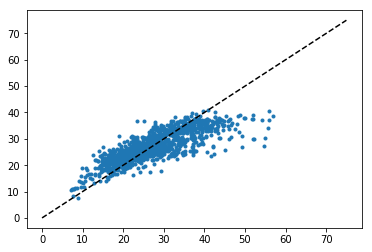

In [15]:
#Plot predictions vs actual
plt.plot(df[target], prediction[target], '.')
plt.plot([0,75],[0,75],'--k')
print('R^2 : ', r2_score(df[target], prediction[target]))

In [16]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

{'type': 'XGBRegressor', 'parameters': {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'n_jobs': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1.0}}


In [ ]:
ds.lookup_job_status_name(analyze_id['job_name'])

In [9]:
ds.delete_model(model)

(True, None)